Import dependencies and read in csvs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
train_df = pd.read_csv('Resources/train.csv')
test_df = pd.read_csv('Resources/test.csv')

Identify null data in train csv and replace nulls.

In [3]:
nulls = pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False))
nulls.head()

,0
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
FireplaceQu,730


In [4]:
def Clear_NA(df):
    df["MasVnrArea"].fillna(0, inplace = True)
    df["LotFrontage"].fillna(0, inplace = True)
    df["GarageArea"].fillna(0, inplace = True)
    df["GarageCars"].fillna(0, inplace = True)
    df["TotalBsmtSF"].fillna(0, inplace = True)
    df.fillna("None", inplace = True)
    df.set_index("Id",inplace = True)

In [5]:
Clear_NA(train_df)

Identify outliers and remove them to prevent outliers from skewing data.

In [6]:
# #find Q1, Q3, and interquartile range for each column
# Q1 = num_data.quantile(q=.25)
# Q3 = num_data.quantile(q=.75)
# IQR = num_data.apply(stats.iqr)

# #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
# num_data_clean = num_data[~((num_data < (Q1-1.5*IQR)) | (num_data > (Q3+1.5*IQR))).any(axis=1)]
# num_data_clean.shape

In [7]:
#find absolute value of z-score for each observation
z = np.abs(stats.zscore(train_df[['LotFrontage',
'LotArea',
'OverallQual',
'OverallCond',
'YearBuilt',
'YearRemodAdd',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageCars',
'GarageArea',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
'YrSold',
'SalePrice'
]]))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
num_data_clean = train_df[(z<3).all(axis=1)]

#find how many rows are left in the dataframe 
num_data_clean.shape

(1027, 80)

Encode the categorical data using pd.get_dummies function.

In [8]:
cleaned_data = pd.get_dummies(data=num_data_clean, columns=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 
'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'])
cleaned_data.head()


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
5,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,0,1,0
7,75.0,10084,8,5,2004,2005,186.0,1369,0,317,...,0,0,0,1,0,0,0,0,1,0
11,70.0,11200,5,5,1965,1965,0.0,906,0,134,...,0,0,0,1,0,0,0,0,1,0


Get correlations on data to identify house features that are most predictive of sales price.

In [9]:
correlations = cleaned_data.corr()
highest_corr = correlations.loc[(correlations["SalePrice"]>.6) | (correlations["SalePrice"]<-.6)]["SalePrice"]

In [10]:
print(highest_corr)

OverallQual     0.813386
YearBuilt       0.633247
TotalBsmtSF     0.625952
GrLivArea       0.757878
FullBath        0.669626
GarageCars      0.697789
GarageArea      0.671904
SalePrice       1.000000
ExterQual_TA   -0.642427
Name: SalePrice, dtype: float64


In [11]:
sale_price = cleaned_data["SalePrice"]
cleaned_data.drop("SalePrice", axis = 1, inplace = True)
# R2 Score: 0.8517171609905699 "OverallQual","GrLivArea","GarageCars","GarageArea","YearBuilt","TotalBsmtSF"
features = cleaned_data[["OverallQual","GrLivArea","GarageCars","GarageArea","YearBuilt","TotalBsmtSF"]]

Split and scale the train data, create the model and test against it using linear regression.

In [12]:
y = sale_price.values.reshape(-1, 1)
X = features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [15]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [16]:
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X_train_scaled, y_train_scaled)

score = model.score(X_train_scaled, y_train_scaled)
print(f"R2 Score: {score}")

R2 Score: 0.8517171609905699


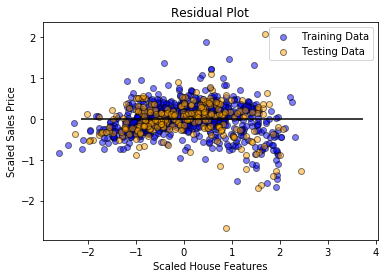

In [17]:
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data", alpha=0.5, edgecolor="black")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data", alpha=0.5, edgecolor="black")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.xlabel('Scaled House Features')
plt.ylabel('Scaled Sales Price')
plt.show()

In [18]:
# Use our model to predict a value
predicted = model.predict(X_train_scaled)

# Score the prediction with mse and r2
mse = mean_squared_error(y_train_scaled, predicted)
r2 = r2_score(y_train_scaled, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 0.1482828390094301
R-squared (R2 ): 0.8517171609905698


Create different models and test the training data against each to identify the best model.

In [19]:
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

Lasso_predictions = lasso.predict(X_test_scaled)

Lasso_MSE = mean_squared_error(y_test_scaled, Lasso_predictions)
Lasso_r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {Lasso_MSE}, R2: {Lasso_r2}")

MSE: 0.207460579053693, R2: 0.8202948791449112


In [20]:
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

Ridge_predictions = ridge.predict(X_test_scaled)

Ridge_MSE = mean_squared_error(y_test_scaled, Ridge_predictions)
Ridge_r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {Ridge_MSE}, R2: {Ridge_r2}")

MSE: 0.2065686515308467, R2: 0.821067478662459


In [21]:
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

Elasticnet_predictions = elasticnet.predict(X_test_scaled)

Elasticnet_MSE = mean_squared_error(y_test_scaled, Elasticnet_predictions)
Elasticnet_r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {Elasticnet_MSE}, R2: {Elasticnet_r2}")

MSE: 0.20707723334353642, R2: 0.8206269383124273


Run the test data on the Ridge model.

In [22]:
Clear_NA(test_df)
X = test_df[["OverallQual","GrLivArea","GarageCars","GarageArea","YearBuilt","TotalBsmtSF"]]

In [23]:
ridge = Ridge(alpha=.01).fit(X_train, y_train)
Ridge_test_predictions = ridge.predict(X)

In [24]:
Ridge_test_predictions.round(2)

array([[127366.84],
       [161747.  ],
       [175212.46],
       ...,
       [153510.65],
       [109825.7 ],
       [234039.84]])

Display the predicted sale price based on each feature. Visible upward trend; as features increases, so does predicted sales price.

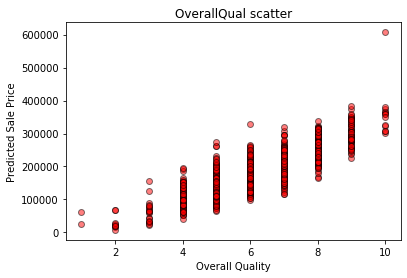

In [25]:
plt.scatter(X["OverallQual"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("OverallQual scatter")
plt.xlabel('Overall Quality')
plt.ylabel('Predicted Sale Price')
plt.show()

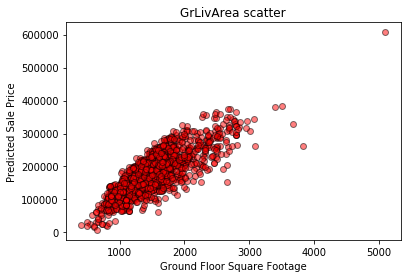

In [26]:
plt.scatter(X["GrLivArea"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("GrLivArea scatter")
plt.xlabel('Ground Floor Square Footage')
plt.ylabel('Predicted Sale Price')
plt.show()

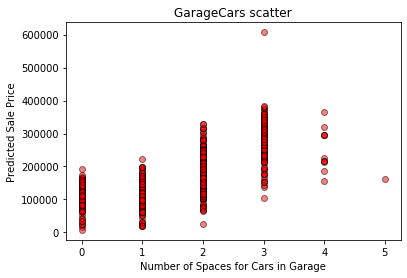

In [27]:
plt.scatter(X["GarageCars"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("GarageCars scatter")
plt.xlabel('Number of Spaces for Cars in Garage')
plt.ylabel('Predicted Sale Price')
plt.show()

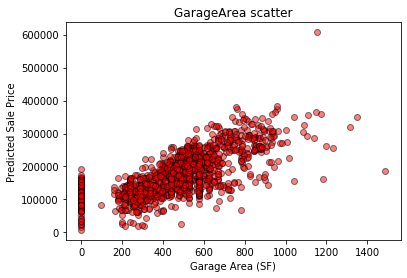

In [28]:
plt.scatter(X["GarageArea"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("GarageArea scatter")
plt.xlabel('Garage Area (SF)')
plt.ylabel('Predicted Sale Price')
plt.show()

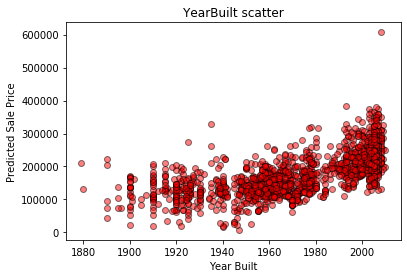

In [29]:
plt.scatter(X["YearBuilt"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("YearBuilt scatter")
plt.xlabel('Year Built')
plt.ylabel('Predicted Sale Price')
plt.show()

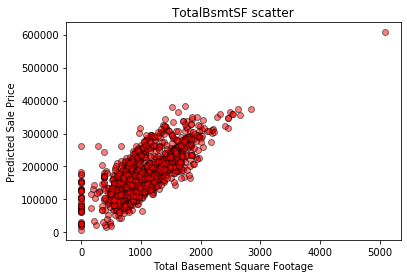

In [30]:
plt.scatter(X["TotalBsmtSF"] ,Ridge_test_predictions , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.title("TotalBsmtSF scatter")
plt.xlabel('Total Basement Square Footage')
plt.ylabel('Predicted Sale Price')
plt.show()

In [31]:
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)
X_scaler = StandardScaler().fit(X)
X_test_scaled = X_scaler.transform(X)
Ridge_test_predictions_scaled = ridge.predict(X_test_scaled)

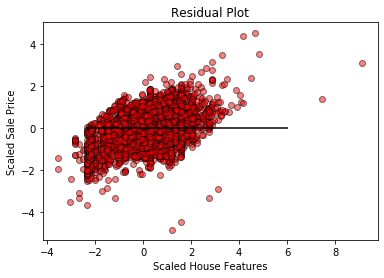

In [32]:
plt.scatter(X_test_scaled , X_test_scaled - Ridge_test_predictions_scaled , c="red", label="Predicted Data", alpha=0.5, edgecolor="black")
plt.hlines(y=0, xmin=Ridge_test_predictions_scaled.min(), xmax=Ridge_test_predictions_scaled.max())
plt.title("Residual Plot")
plt.xlabel('Scaled House Features')
plt.ylabel('Scaled Sale Price')
plt.show()